## Spectral clustering

Spectral clustering is a powerful technique for clustering data into groups based on their similarities. It utilizes the spectral properties of a similarity or affinity matrix derived from the data. This method is particularly useful when traditional clustering algorithms like K-means or hierarchical clustering are not effective due to the non-convex or complex structures within the data.

The key steps in spectral clustering are as follows:

1. **Similarity Matrix**: Calculate a similarity or affinity matrix that quantifies the relationships between data points. Common choices for similarity measures include nearest neighbors, radial basis function (RBF) kernel, or cosine similarity.

2. **Graph Representation**: Convert the similarity matrix into a graph representation, where each data point is a node, and the similarity values determine the edge weights between nodes. This graph is often referred to as a "similarity graph."

3. **Graph Laplacian**: Compute the Laplacian matrix of the graph, which encodes the graph's spectral properties. There are different types of Laplacian matrices, such as the unnormalized Laplacian, normalized Laplacian, or symmetric normalized Laplacian.

4. **Eigenvalue Decomposition**: Perform eigenvalue decomposition on the Laplacian matrix to obtain the eigenvectors and eigenvalues. These eigenvectors capture the spectral properties of the data.

5. **Dimension Reduction**: Select a subset of the eigenvectors (usually the first k eigenvectors) to represent the data in a lower-dimensional space. This step reduces the dimensionality of the data.

6. **Clustering**: Apply a traditional clustering algorithm (e.g., K-means or hierarchical clustering) to the reduced-dimensional data. The number of clusters is determined by the specific problem and is not constrained by the dimensionality of the data.

Spectral clustering is effective at identifying clusters with complex shapes and handling data that may not be linearly separable. It is widely used in image segmentation, community detection in networks, and various data analysis tasks where traditional clustering methods may fall short.

Keep in mind that spectral clustering's performance depends on parameters like the number of clusters and the choice of similarity measure. Experimentation and tuning are often required to obtain optimal results for your specific dataset.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pickle

import sys
import os
sys.path.append('../..')
from src.utils.directories import get_parent_directory
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
parent_dir = get_parent_directory()
all_pkl_path = (os.path.join(parent_dir, "data/processed/ml_ready/merged_arctic.pkl"))

with open(all_pkl_path, 'rb') as f:
    data = pickle.load(f)

# clustering preparation

In [3]:
data = data[data['S'] >= 20]
data = data.dropna()

max_points_per_latitude = 5

# Subsample the DataFrame
subsampled_df = data.groupby('latitude', group_keys=False).apply(lambda group: group.sample(n=min(max_points_per_latitude, len(group)), random_state=42))

# Reset the index of the subsampled DataFrame
subsampled_df.reset_index(drop=True, inplace=True)

In [ ]:
# Plot a histogram of the 'latitude' column
plt.hist(subsampled_df['seasonal_sin'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Periodic time')
plt.ylabel('Frequency')
plt.title('Histogram of Latitude in Subsampled Data')
plt.grid(True)

# Show the histogram
plt.show()


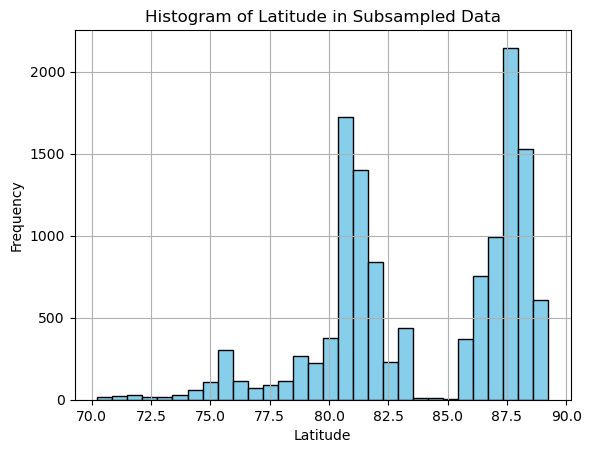

In [7]:
# Plot a histogram of the 'latitude' column
plt.hist(subsampled_df['latitude'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Latitude')
plt.ylabel('Frequency')
plt.title('Histogram of Latitude in Subsampled Data')
plt.grid(True)

# Show the histogram
plt.show()


In [8]:
var_df = subsampled_df[['S', 'T', 'log_eps', 'log_N2', 'dTdz', 'dSdz', 'seasonal_sin']]

# Keep the column names
column_names = var_df.columns

X = var_df

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add the column names back to the X_scaled array
X_scaled = pd.DataFrame(X_scaled, columns=column_names)

# Find optimal number of clusters

**Silhouette Score**:

The silhouette score is a metric used to evaluate the quality of clusters in a clustering analysis. It measures how similar each data point is to its own cluster (cohesion) compared to other clusters (separation). The silhouette score ranges from -1 to 1, where higher values indicate better clustering quality. The formula for calculating the silhouette score is as follows:

\[
\text{Silhouette Score} = \frac{b - a}{\max(a, b)}
\]

Where:
- \(a\) represents the average distance from a data point to other points in the same cluster (cohesion).
- \(b\) represents the minimum average distance from a data point to points in a different cluster (separation).

The silhouette score has the following interpretations:
- If the cohesion within the same cluster (\(a\)) is much smaller than the separation from other clusters (\(b\)), the silhouette score is close to 1, indicating that data points are well-matched to their own clusters.
- If the separation (\(b\)) is much smaller than the cohesion (\(a\)), the silhouette score is close to -1, suggesting that data points are poorly matched to their own clusters.
- A silhouette score near 0 indicates that a data point is near the decision boundary between two neighboring clusters.

In practice, a higher average silhouette score suggests better clustering, and the optimal number of clusters is often selected by comparing silhouette scores for different cluster numbers and choosing the number that maximizes the score. The silhouette score helps assess clustering quality and guide the selection of the appropriate number of clusters for the data.



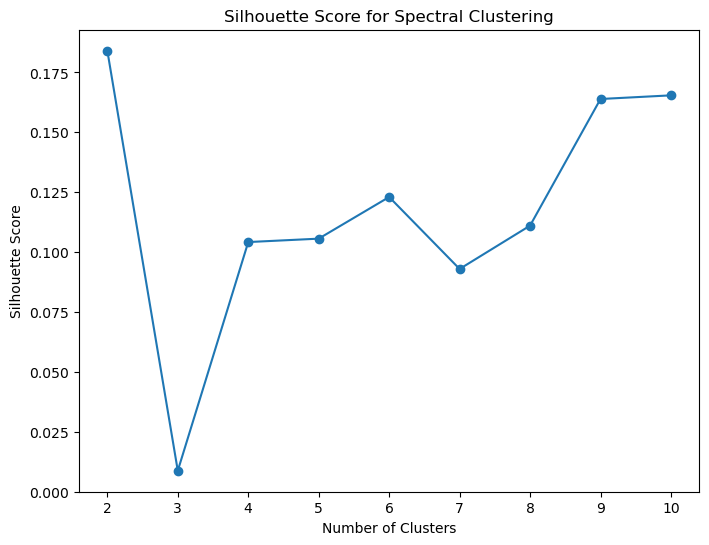

In [7]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Create an array to store silhouette scores
silhouette_scores = []

# Define a range of cluster numbers to test
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Perform spectral clustering for different cluster numbers and record silhouette scores
for n_clusters in range_n_clusters:
    spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=10)
    cluster_labels = spectral_clustering.fit_predict(X_scaled)
    
    # Calculate the silhouette score and record it
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Create a plot for the silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Spectral Clustering')
plt.show()


## Perform spectral clustering

In [11]:
from sklearn.cluster import SpectralClustering
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import adjusted_rand_score, homogeneity_score

# Define a range of hyperparameters to search
param_grid = {
    'n_clusters': [3],  # Adjust the number of clusters
    'affinity': ['nearest_neighbors', 'rbf'],  # Experiment with different affinity measures
    'n_neighbors': [5, 10],  # Adjust the number of neighbors (if using nearest_neighbors)
}
# Instantiate the Spectral Clustering model
spectral_clustering = SpectralClustering()

# Use Grid Search to find the best combination of hyperparameters
grid_search = GridSearchCV(spectral_clustering, param_grid, scoring=adjusted_rand_score, n_jobs=-1)
grid_search.fit(X_scaled)  # Assuming X_scaled is your scaled data

# Get the best parameters and best adjusted Rand score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Adjusted Rand Score:", best_score)


/Users/Lisanne/opt/anaconda3/envs/arcticT/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/Lisanne/opt/anaconda3/envs/arcticT/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Lisanne/opt/anaconda3/envs/arcticT/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/Lisanne/opt/anaconda3/envs/arcticT/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py", line 401, in adjusted_rand_score
    (tn, fp), (fn, tp) = pair_confusion_matrix(labels_true, labels_pred)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

# Acually cluster

In [9]:
var_df = data[['S', 'T', 'log_eps', 'log_N2', 'dTdz', 'dSdz', 'seasonal_sin']]

# Keep the column names
column_names = var_df.columns

X = var_df

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add the column names back to the X_scaled array
X_scaled = pd.DataFrame(X_scaled, columns=column_names)

In [10]:
X = X_scaled

from sklearn.cluster import SpectralClustering

# Instantiate the Spectral Clustering model
n_clusters = 3  # The number of clusters to form
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=20) #10
# spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='rbf', n_neighbors=10)

# Fit the Spectral Clustering model to your scaled data
cluster_labels = spectral_clustering.fit_predict(X_scaled)

# Evaluate clusters

In [10]:
X_input = X[['S', 'T', 'log_eps', 'log_N2', 'dTdz', 'dSdz', 'seasonal_sin']]
# X_output = X[['Cluster']]

# Use the inverse_transform method to anti-scale X_scaled
transformed_df = pd.DataFrame(scaler.inverse_transform(X_input), columns=X_input.columns)

# Add cluster labels to the DataFrame
transformed_df['Cluster'] = spectral_clustering.labels_

# Round the values in the DataFrames to a specific number of decimal places
decimals = 4  # Adjust as needed
data_rounded = data.round(decimals)
transformed_df_rounded = transformed_df.round(decimals)

# Merge based on multiple columns (A and B)
merged_df = transformed_df_rounded.merge(data_rounded, on=['S', 'T', 'log_eps', 'log_N2', 'dSdz', 'dTdz', 'seasonal_sin'], how='left')

cluster_crisis_groups = merged_df.groupby(['Cluster', 'cruise']).size().unstack(fill_value=0)
cluster_crisis_groups

cruise,ABSO,ASCOS,Haakon Mosby,IPY Barneo 2007,IPY Barneo 2008,Mosaic,NICE-2015,Nansen Legacy 2018,Nansen Legacy 2019,TEA_COSI
Cluster,,,,,,,,,,
0,1,489,2,171,576,2497,780,2,0,32
1,0,529,240,284,284,2687,2140,387,215,2
2,367,0,1,0,0,1,5,2,0,1198


In [56]:
# Analyse cluster 0
cluster_0_data = merged_df[merged_df['Cluster'] == 0]
cluster_0_statistics = cluster_0_data.describe()
print(cluster_0_statistics)

                 S            T      log_eps       log_N2         dTdz  \
count  6766.000000  6766.000000  6766.000000  6766.000000  6766.000000   
mean     34.768328     1.446000    -8.966143    -5.057050     0.021371   
std       0.220728     1.307504     0.457542     0.801423     0.055870   
min      29.136200    -1.721300   -10.767600   -20.101500    -0.433000   
25%      34.655750     0.733575    -9.206200    -5.555525     0.000000   
50%      34.816800     1.224450    -9.004200    -4.936150     0.008600   
75%      34.909075     2.228375    -8.748000    -4.486375     0.027500   
max      35.110500     7.703800    -2.846600    -2.398300     0.842800   

              dSdz  seasonal_sin  Cluster        depth      profile  \
count  6766.000000   6766.000000   6766.0  6764.000000  6764.000000   
mean      0.004955      0.071320      0.0   191.005854   731.367482   
std       0.012095      0.698263      0.0    95.349108   593.194790   
min      -0.084100     -0.999900      0.0     5.0

In [57]:
# Analyse cluster 1
cluster_0_data = merged_df[merged_df['Cluster'] == 1]
cluster_0_statistics = cluster_0_data.describe()
print(cluster_0_statistics)

                 S           T      log_eps       log_N2         dTdz  \
count  4554.000000  4554.00000  4554.000000  4554.000000  4554.000000   
mean     33.447316    -1.58975    -8.570340    -4.513214     0.006422   
std       0.950447     0.32357     0.842642     0.835594     0.015367   
min      25.339700    -1.89000   -10.556200    -8.387600    -0.224400   
25%      32.935775    -1.79060    -9.111700    -4.966075    -0.000100   
50%      33.783850    -1.73245    -8.874750    -4.368850     0.000500   
75%      34.250075    -1.53600    -8.321875    -3.971200     0.012400   
max      34.725400     0.69610    -3.337000    -2.148100     0.121000   

              dSdz  seasonal_sin  Cluster        depth      profile  \
count  4554.000000   4554.000000   4554.0  4554.000000  4554.000000   
mean      0.016701     -0.020096      1.0    60.440082   631.248518   
std       0.045291      0.701460      0.0    41.022267   526.654502   
min      -0.059500     -0.999900      1.0     2.000000    

In [58]:
# Analyse cluster 1
cluster_0_data = merged_df[merged_df['Cluster'] == 2]
cluster_0_statistics = cluster_0_data.describe()
print(cluster_0_statistics)

                 S            T      log_eps       log_N2         dTdz  \
count  1581.000000  1581.000000  1581.000000  1581.000000  1581.000000   
mean     33.539001     0.626364    -5.585964   -11.386126    -0.036920   
std       2.009875     2.517162     0.937723     2.820475     0.172588   
min      20.621800    -2.440900    -8.595500   -28.369100    -1.923500   
25%      33.216300    -1.540600    -6.119200   -12.668000    -0.020600   
50%      34.274200    -0.238200    -5.799700   -11.094500    -0.002700   
75%      34.852000     2.036000    -5.381000    -9.680300     0.007500   
max      35.755400     7.864900    -0.016800    -2.738700     0.397400   

              dSdz  seasonal_sin  Cluster        depth      profile  \
count  1581.000000   1581.000000   1581.0  1574.000000  1574.000000   
mean      0.055716      0.087012      2.0   106.187319   183.522236   
std       0.531413      0.229185      0.0   109.208779   130.685470   
min      -7.851100     -0.943500      2.0     2.0

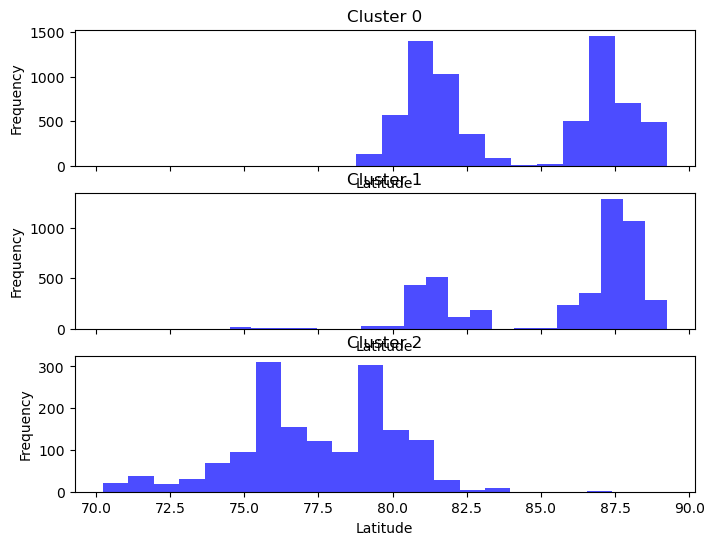

In [59]:
# Create a figure and axis for the histograms
fig, axes = plt.subplots(len(set(merged_df['Cluster'])), figsize=(8, 6), sharex=True)

for cluster_label, ax in zip(set(merged_df['Cluster']), axes):
    # Filter data points for the current cluster
    cluster_data = merged_df[merged_df['Cluster'] == cluster_label]
    
    # Plot a histogram of the latitude values for the current cluster
    ax.hist(cluster_data['latitude'], bins=20, alpha=0.7, color='blue')
    ax.set_title(f'Cluster {cluster_label}')
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Frequency')

#plt.tight_layout()
plt.show()


## Plot clusters

The Silhouette Coefficient ranges from -1 to 1 and is calculated for each data point. Here's what the values mean:

Near +1: This indicates that the data point is well inside its own cluster and far from other clusters. A high Silhouette Coefficient suggests that the object is well matched to its own cluster and poorly matched to neighboring clusters.

Near 0: A value close to 0 suggests that the data point is on or very close to the decision boundary between two neighboring clusters. In this case, it could belong to either of the clusters or perhaps to a cluster in between.

Near -1: A value close to -1 indicates that the data point is probably assigned to the wrong cluster. It is far from its own cluster and very close to another cluster, suggesting a poor clustering solution.

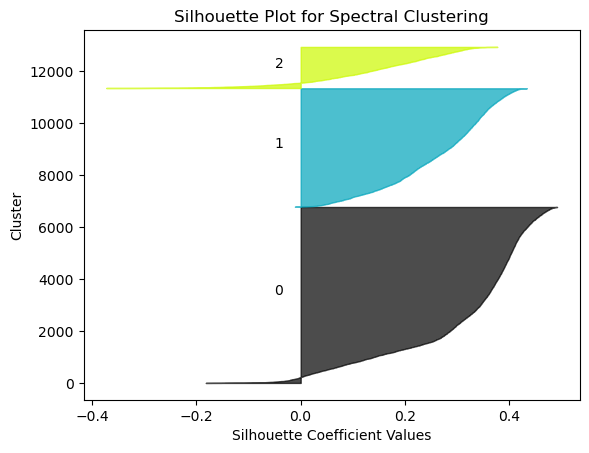

In [60]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

silhouette_avg = silhouette_score(X, cluster_labels)
sample_silhouette_values = silhouette_samples(X, cluster_labels)

# Create a silhouette plot
y_lower = 10
for i in range(len(set(cluster_labels))):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / len(set(cluster_labels)))
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # Add 10 for the next plot

# Add a title and axis labels
plt.title("Silhouette Plot for Spectral Clustering")
plt.xlabel("Silhouette Coefficient Values")
plt.ylabel("Cluster")

# Show the plot
plt.show()

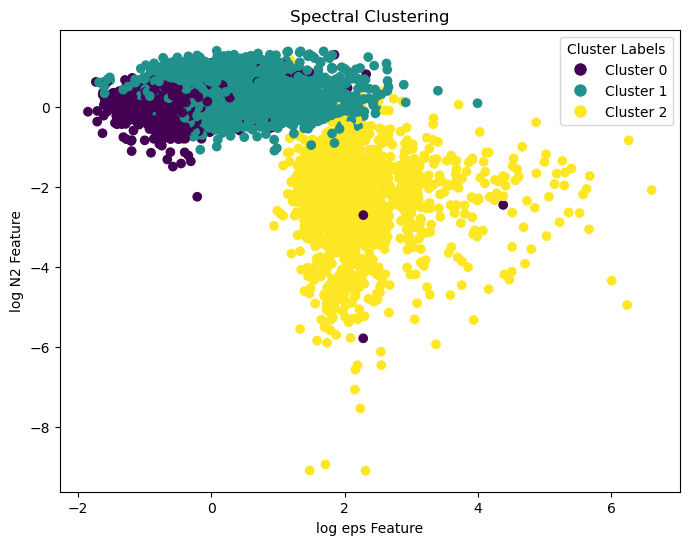

In [61]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Assuming you have cluster_labels and X as specified in your previous code

# Select the two features (N2 and T) for plotting
feature_N = X['log_eps']
feature_T = X['log_N2']

# Create a scatter plot with cluster assignments
plt.figure(figsize=(8, 6))
scatter = plt.scatter(feature_N, feature_T, c=cluster_labels, cmap='viridis')

# Get unique cluster labels
unique_labels = list(set(cluster_labels))

# Create custom legend handles with corresponding labels and colors
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.to_rgba(label), markersize=10, label=f'Cluster {label}') for label in unique_labels]

# Set plot titles and labels
plt.title('Spectral Clustering')
plt.xlabel('log eps Feature')
plt.ylabel('log N2 Feature')

# Show the legend and the plot
plt.legend(handles=legend_handles, title="Cluster Labels")
plt.show()


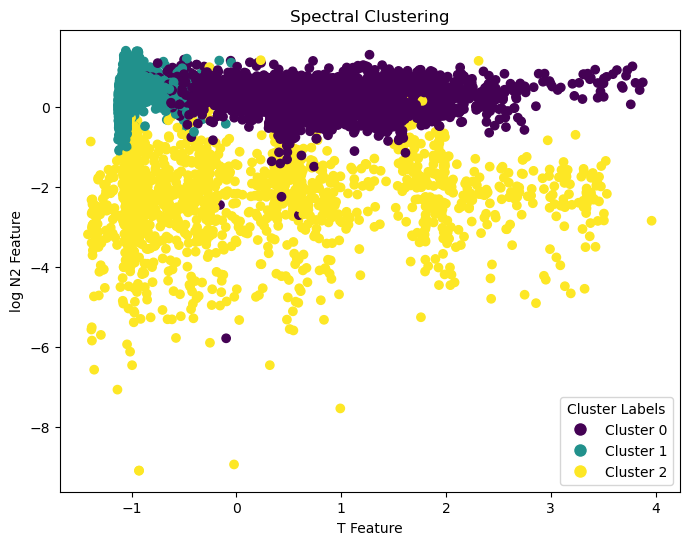

In [62]:
# Select the two features (N2 and T) for plotting
feature_N = X['T']
feature_T = X['log_N2']

# Create a scatter plot with cluster assignments
plt.figure(figsize=(8, 6))
scatter = plt.scatter(feature_N, feature_T, c=cluster_labels, cmap='viridis')

# Get unique cluster labels
unique_labels = list(set(cluster_labels))

# Create custom legend handles with corresponding labels and colors
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.to_rgba(label), markersize=10, label=f'Cluster {label}') for label in unique_labels]

# Set plot titles and labels
plt.title('Spectral Clustering')
plt.xlabel('T Feature')
plt.ylabel('log N2 Feature')

# Show the legend and the plot
plt.legend(handles=legend_handles, title="Cluster Labels")
plt.show()



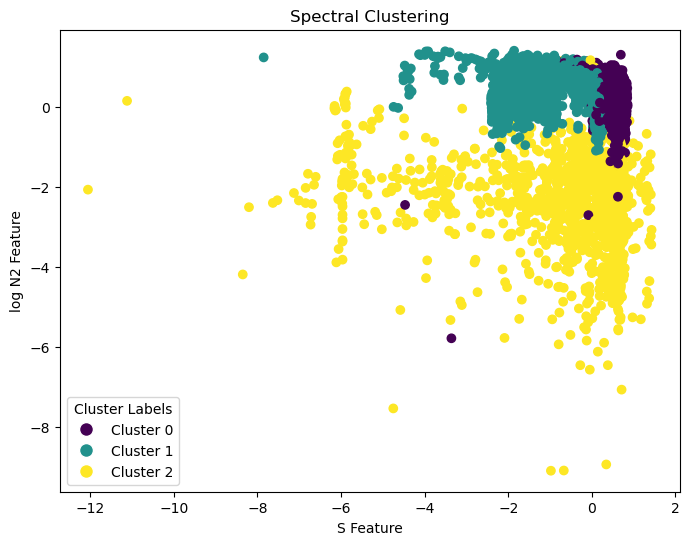

In [63]:
# Select the two features (N2 and T) for plotting
feature_N = X['S']
feature_T = X['log_N2']

# Create a scatter plot with cluster assignments
plt.figure(figsize=(8, 6))
scatter = plt.scatter(feature_N, feature_T, c=cluster_labels, cmap='viridis')

# Get unique cluster labels
unique_labels = list(set(cluster_labels))

# Create custom legend handles with corresponding labels and colors
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.to_rgba(label), markersize=10, label=f'Cluster {label}') for label in unique_labels]

# Set plot titles and labels
plt.title('Spectral Clustering')
plt.xlabel('S Feature')
plt.ylabel('log N2 Feature')

# Show the legend and the plot
plt.legend(handles=legend_handles, title="Cluster Labels")
plt.show()


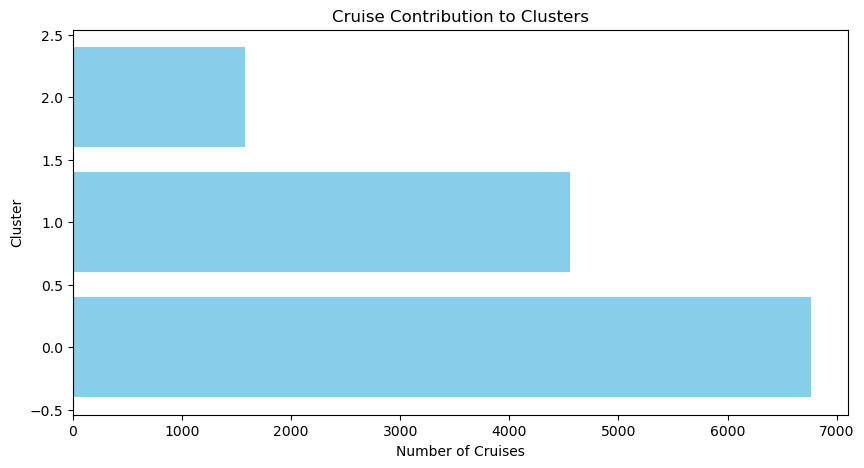

In [64]:
# Count the number of cruises in each cluster
cluster_counts = merged_df['Cluster'].value_counts().sort_index()

# Create a horizontal bar plot
plt.figure(figsize=(10, 5))
plt.barh(cluster_counts.index, cluster_counts.values, color='skyblue')

# Customize the plot
plt.ylabel('Cluster')
plt.xlabel('Number of Cruises')
plt.title('Cruise Contribution to Clusters')

# Show the plot
plt.show()

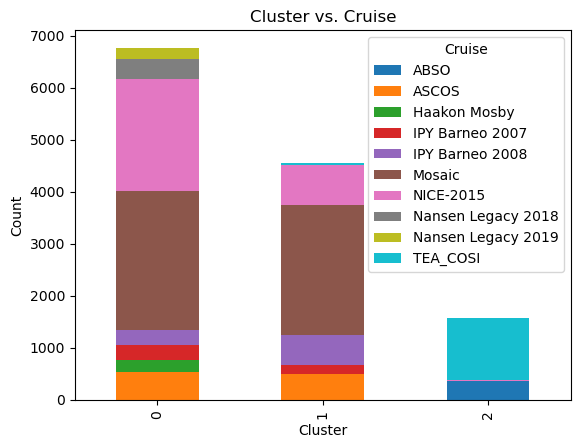

In [66]:
import matplotlib.pyplot as plt

# Bar plot for cluster vs. crisis
cluster_crisis_groups.plot(kind='bar', stacked=True)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Cluster vs. Cruise')
plt.legend(title='Cruise')
plt.show()

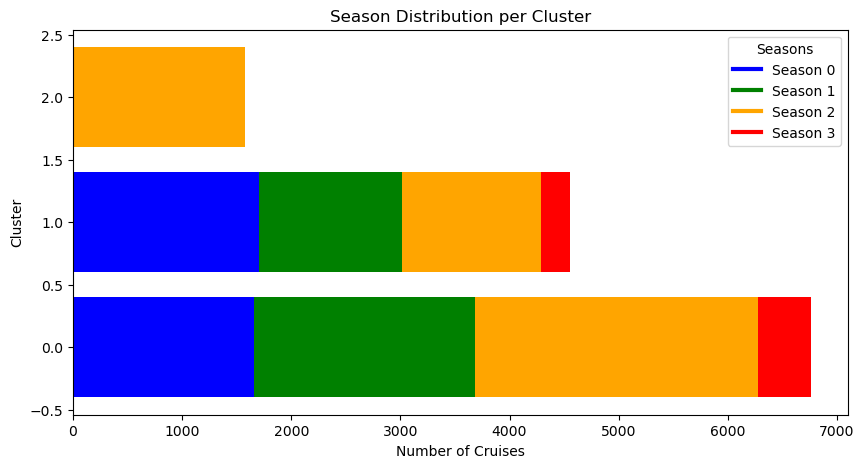

In [67]:
# Define a color map for seasons
season_colors = {0: 'blue', 1: 'green', 2: 'orange', 3: 'red'}

# Map season values to colors
merged_df['Color'] = merged_df['season'].map(season_colors)

# Count the number of cruises in each cluster for each season
cluster_season_counts = merged_df.groupby(['Cluster', 'season']).size().unstack().fillna(0)

# Create a horizontal bar plot with colored segments for seasons
plt.figure(figsize=(10, 5))
bottom = None

for season in range(4):  # Assuming 4 seasons (0 to 3)
    season_label = f'Season {season}'
    plt.barh(cluster_season_counts.index, cluster_season_counts[season], left=bottom, color=season_colors[season], label=season_label)
    if bottom is None:
        bottom = cluster_season_counts[season]
    else:
        bottom += cluster_season_counts[season]

# Customize the plot
plt.ylabel('Cluster')
plt.xlabel('Number of Cruises')
plt.title('Season Distribution per Cluster')

# Show the legend for season colors
legend_labels = [plt.Line2D([0], [0], color=color, lw=3, label=f'Season {season}') for season, color in season_colors.items()]
plt.legend(handles=legend_labels, title='Seasons')

# Show the plot
plt.show()